# ==========================================================
# MSCS 634 - Advanced Big Data Mining
# Project Deliverable 2
# Professor - Dr. Satish Penmatsa
# ==========================================================

# Team Members
# Prashanna Acharya, Bikash Shrestha, Bibek Itani, Ujjwal Khadka, Abhishek Pandey, Sahil Rauniyar


#  1. Importing Libraries 

In [1]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, KFold, cross_validate
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import r2_score, mean_squared_error

from sklearn.linear_model import LinearRegression, Ridge, Lasso


# 2. Loading Clean Dataset 

In [2]:
# Load cleaned dataset
data = pd.read_csv("cleaned_stroke_data.csv")


print("Dataset shape:", data.shape)
display(data.head())


Dataset shape: (3814, 12)


,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,30669,male,3.0,0,0,no,children,rural,95.12,18.0,unknown,0
1,16523,female,8.0,0,0,no,private,urban,110.89,17.6,unknown,0
2,56543,female,70.0,0,0,yes,private,rural,69.04,35.9,formerly smoked,0
3,46136,male,14.0,0,0,no,never_worked,rural,161.28,19.1,unknown,0
4,52800,female,52.0,0,0,yes,private,urban,77.59,17.7,formerly smoked,0


## 3. Feature Engineering

In [3]:
# Age group bins
age_bins = [0, 5, 12, 17, 29, 44, 59, 74, 89, 100]
age_labels = ["0-5", "6-12", "13-17", "18-29", "30-44", "45-59", "60-74", "75-89", "90+"]
data["age_group"] = pd.cut(data["age"], bins=age_bins, labels=age_labels, include_lowest=True)

# BMI categories
bmi_bins = [0, 18.5, 24.9, 29.9, 100]
bmi_labels = ["underweight", "normal", "overweight", "obese"]
data["bmi_category"] = pd.cut(data["bmi"], bins=bmi_bins, labels=bmi_labels, include_lowest=True)

# Cardiovascular risk score
data["cardio_risk_score"] = data["hypertension"].astype(int) + data["heart_disease"].astype(int)

# Interaction feature
data["age_bmi_interaction"] = data["age"] * data["bmi"]

display(data[["age", "age_group", "bmi", "bmi_category", "cardio_risk_score","age_bmi_interaction", "avg_glucose_level"]].head())


,age,age_group,bmi,bmi_category,cardio_risk_score,age_bmi_interaction,avg_glucose_level
0,3.0,0-5,18.0,underweight,0,54.0,95.12
1,8.0,6-12,17.6,underweight,0,140.8,110.89
2,70.0,60-74,35.9,obese,0,2513.0,69.04
3,14.0,13-17,19.1,normal,0,267.4,161.28
4,52.0,45-59,17.7,underweight,0,920.4,77.59


## 4. Train/Test Split

In [4]:
target = "bmi"

# Drop leakage features
X = data.drop(columns=[target,"bmi_category","age_bmi_interaction"], errors="ignore")

if "id" in X.columns:
    X = X.drop(columns=["id"])
    
y = data[target]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

## 5. Preprocessing Pipeline

In [5]:
# Identify numeric and categorical columns
numeric_features = X_train.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_features = X_train.select_dtypes(include=["object", "category"]).columns.tolist()

# Numeric preprocessing
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

# Categorical preprocessing
categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

# Combining
preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)


## 6. Regression Models

In [6]:
models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(alpha=1.0, random_state=42),
    "Lasso Regression": Lasso(alpha=0.01, random_state=42, max_iter=5000)
}

pipelines = {
    name: Pipeline(steps=[("preprocess", preprocess),
                         ("model", model)])
    for name, model in models.items()
}

list(pipelines.keys())


['Linear Regression', 'Ridge Regression', 'Lasso Regression']

## 7. Cross-Validation (R², MSE, RMSE)

In [7]:
cv = KFold(n_splits=5, shuffle=True, random_state=42)

scoring = {
    "r2": "r2",
    "neg_mse": "neg_mean_squared_error",
    "neg_rmse": "neg_root_mean_squared_error"
}

fold_metrics = {}
summary_rows = []

for name, pipe in pipelines.items():
    scores = cross_validate(pipe, X_train, y_train, cv=cv, scoring=scoring)
    
    r2_folds = scores["test_r2"]
    mse_folds = -scores["test_neg_mse"]
    rmse_folds = -scores["test_neg_rmse"]
    
    fold_metrics[name] = {
        "r2": r2_folds,
        "mse": mse_folds,
        "rmse": rmse_folds
    }
    
    summary_rows.append({
        "Model": name,
        "Mean_CV_R2": r2_folds.mean(),
        "Mean_CV_MSE": mse_folds.mean(),
        "Mean_CV_RMSE": rmse_folds.mean()
    })

cv_df = pd.DataFrame(summary_rows).sort_values("Mean_CV_RMSE")
display(cv_df)


,Model,Mean_CV_R2,Mean_CV_MSE,Mean_CV_RMSE
2,Lasso Regression,0.285158,31.139900,5.580062
1,Ridge Regression,0.283315,31.220732,5.587291
0,Linear Regression,0.283002,31.234317,5.588504


## Visualization 1: R² Across CV Folds (Line Plot)

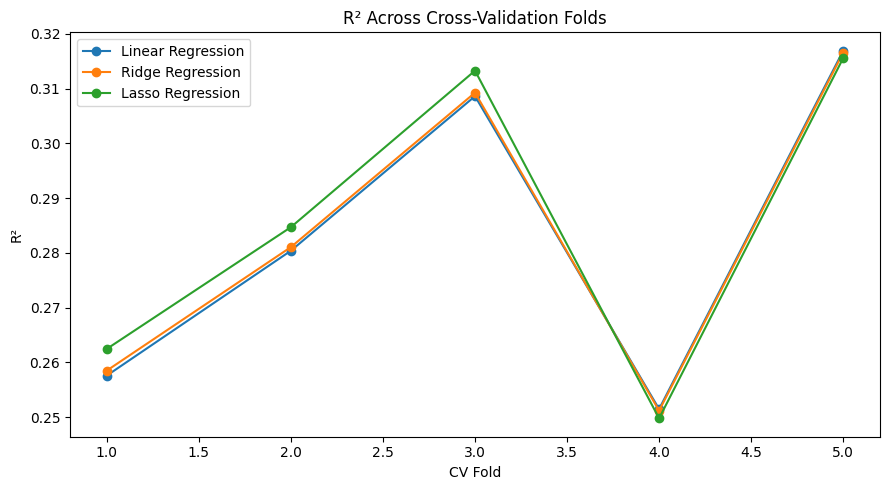

In [8]:
plt.figure(figsize=(9, 5))
for name, metrics in fold_metrics.items():
    plt.plot(range(1, 6), metrics["r2"], marker="o", label=name)

plt.xlabel("CV Fold")
plt.ylabel("R²")
plt.title("R² Across Cross-Validation Folds")
plt.legend()
plt.tight_layout()
plt.show()


## Visualization 2: Mean CV R² (Bar Chart)

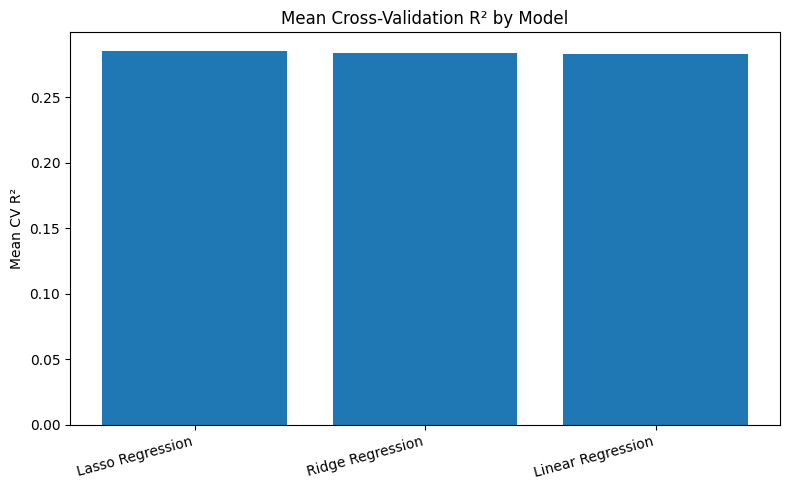

In [9]:
# Bar chart of mean R² by model
plt.figure(figsize=(8, 5))
plt.bar(cv_df["Model"], cv_df["Mean_CV_R2"])
plt.ylabel("Mean CV R²")
plt.title("Mean Cross-Validation R² by Model")
plt.xticks(rotation=15, ha="right")
plt.tight_layout()
plt.show()


## Visualization 3: RMSE Across CV Folds (Line Plot)

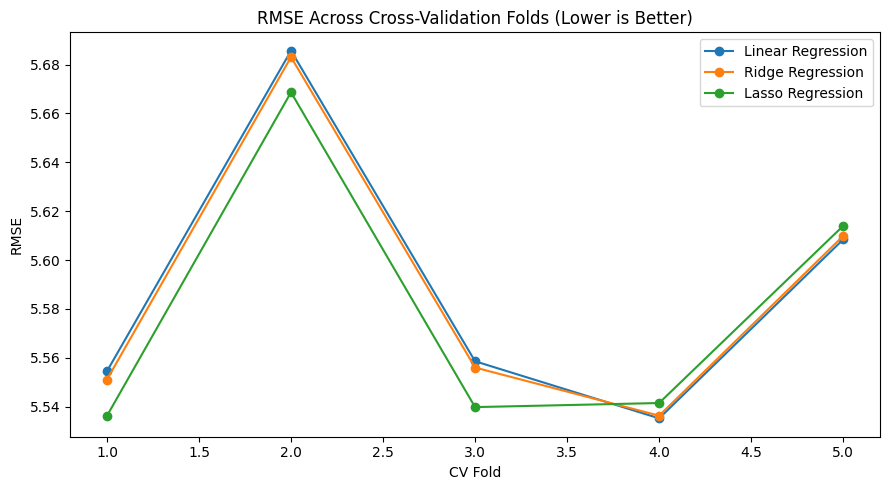

In [10]:
plt.figure(figsize=(9, 5))
for name, metrics in fold_metrics.items():
    plt.plot(range(1, 6), metrics["rmse"], marker="o", label=name)

plt.xlabel("CV Fold")
plt.ylabel("RMSE")
plt.title("RMSE Across Cross-Validation Folds (Lower is Better)")
plt.legend()
plt.tight_layout()
plt.show()


## Visualization 4: MSE Across CV Folds (Line Plot)

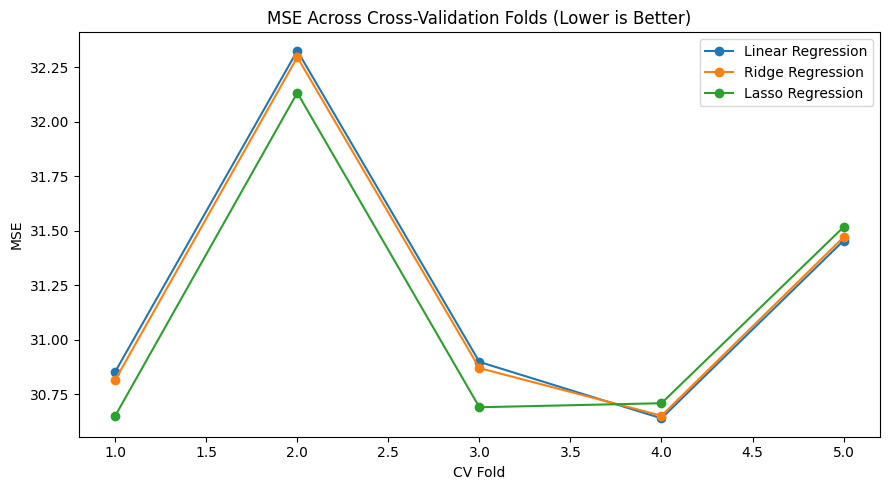

In [11]:
plt.figure(figsize=(9, 5))
for name, metrics in fold_metrics.items():
    plt.plot(range(1, 6), metrics["mse"], marker="o", label=name)

plt.xlabel("CV Fold")
plt.ylabel("MSE")
plt.title("MSE Across Cross-Validation Folds (Lower is Better)")
plt.legend()
plt.tight_layout()
plt.show()


## 8. Best Model and Evaluation

In [ ]:
# Selecting best model using lowest Mean CV RMSE
best_model_name = cv_df.iloc[0]["Model"]
best_pipe = pipelines[best_model_name]

best_pipe.fit(X_train, y_train)
y_pred = best_pipe.predict(X_test)

test_r2 = r2_score(y_test, y_pred)
test_mse = mean_squared_error(y_test, y_pred)
test_rmse = np.sqrt(test_mse)

print("Best Model (lowest Mean CV RMSE):", best_model_name)
print(f"Test R²  : {test_r2:.4f}")
print(f"Test MSE : {test_mse:.4f}")
print(f"Test RMSE: {test_rmse:.4f}")


Best Model (lowest Mean CV RMSE): Lasso Regression
Test R²  : 0.3101
Test MSE : 31.4852
Test RMSE: 5.6112


## Final Summary Table

In [13]:
final_table = cv_df.copy()
final_table["Best_Model_Selected"] = final_table["Model"].apply(lambda m: "YES" if m == best_model_name else "")
display(final_table)


,Model,Mean_CV_R2,Mean_CV_MSE,Mean_CV_RMSE,Best_Model_Selected
2,Lasso Regression,0.285158,31.139900,5.580062,YES
1,Ridge Regression,0.283315,31.220732,5.587291,
0,Linear Regression,0.283002,31.234317,5.588504,



# Model Evaluation Results and Key Insights

- Three regression models were tested and analyzed which were linear regression, ridge regression, lasso regression.

- All three regression models were evaluated using a five fold cross validation procedure and assessment was made using the mean squared error (MSE), root mean squared error (RMSE), and r-squared (R²) measures.

- Lasso regression produced the highest average r squared as well as lowest average RMSE on all cross validation splits which indicated better prediction than the other two models making lasso regression the best model.

- Lasso regression had the most stable predictions from split to split compared to both linear and ridge regression.

- Although linear regression performed fairly well, its predictions were less accurate than those of lasso and ridge regression suggesting that it is sensitive to correlation between features.

- Cross validation results show that the models that used regularization are able to perform better than the non-regularized models when making predictions based on new unseen data.

- Feature engineering such as use of age groups, BMI categories, cardiovascular risk score, and use of interaction terms increased the performance of the models and their interpretability.

- Based on performance and ability to predict accurately and consistently across multiple splits of the data, the lasso regression model was determined to be the best model.

